# Module 2: Inversion

In the previous module we started with a continuous distribution of a physical property and discretized it into many cells, then we performed a forward simulation that created data from known model parameters. Inversion, of course, is exactly the opposite process. Imagine each model parameter that we had represents a layer in a 1D layered earth. At the surface of the earth we measure the data, and when we invert we do so for the model parameters. Our goal is to take the observed data and recover models that emulate the real Earth as closely as possible. 

You may have noticed that the act of discretizing our problem created more cells than data values. In our latter example we produced 20 data points from 1000 model parameters, which is only a few data points and many model parameters. While this was not much of a problem in the forward simulation, when we want to do the inverse process, that is, obtain the model parameters from the data, it is clear that we have many more unknowns than knowns. In short, we have an underdetermined problem, and therefore infinite possible solutions. In mathematical terms, geophysical surveys represent what are called "ill-posed" problems. 

An "ill-posed" problem is any problem that does not satisfy the requirements for the definition of "well-posed" problem. A *well-posed* problem is a problem in mathematics that must satisfy all three of the following criteria:

<ol>
<li> A solution exists.
<li> The solution is unique.
<li> The solution's behaviors change continuously with continuously changing initial conditions.
</ol>

Any mathematical formulation that does not satisfy all three of the above is, by definition, an ill-posed problem. Since we are dealing with an underdetermined system, I hope that it is clear that we are dealing with an ill-posed problem (i.e., we have no unique solution), and we are going to have to come up with  a method (or methods) that can help us choose from the available solutions. We need to devise an algorithm that can choose the "best" model from the infinitely many that are available to us. 

In short, we are going to have to find an optimum model. More specifically, in the context of most geophysics problems, we are going to use gradient-based optimization. This process involves building an *objective function*, which is a function that casts our inverse problem as an optimization problem. We will build an objective function consisting of two parts:

$$
\phi = \phi_d + \beta \phi_m
$$

Where the terms on the right hand side are (1) a data misfit (denoted as $\phi_d$) and (2) a model regularization (denoted as $\phi_m$). These two parts will be elaborated in detail below.

Once we have formulated the objective function, we will take derivatives and obtain a recovered model. This module will flesh out the details of the model objective function, and then take first and second derivatives to derive an expression that gives us a solution for our model parameters.



## The Data Misfit, $\phi_d$

A *misfit* describes how close synthetic data matches measurements that are made in the field. Traditionally this term refers to the difference between the measured data and the predicted data. If these two quantities are sufficiently close, then we consider the model to be a viable candidate for the solution to our problem. Because the data are inaccurate, a model that reproduces those data exactly is not feasible. A realistic goal, rather, is to find a model whose predicted data are consistent with the errors in the observations, and this requires incorporating knowledge about the noise and uncertainties. The concept of fitting the data means that some estimate of the “noise” be available. Unfortunately “noise” within the context of inversion is everything that cannot be accounted for by a compatible relationship between the model and the data. More specifically, noise refers to (1) noise from data aquisition in the field, (2) uncertainty in source and receiver locations, (3) numerical error, (4) physical assumptions about our model that do not capture all of the physics. 

A standard approach is to assume that each datum, $d_i$, contains errors that can be described as Gaussian with a standard deviation $\epsilon_i$. It is important to give a significant amount of thought towards assigning standard deviations in the data, but a reasonable starting point is to assign each $\epsilon_i$ as $\epsilon_i= floor +\%|d_i|$. 

Incorporating both the differences between predicted and measured data and a measure of the uncertainties in the data yields our misfit function, $\phi_d$:

$$
\phi_d (m) = \frac{1}{2} \sum_{i=1}^N \left( \frac{F[m] -d_i^{obs} }{\epsilon_i}\right)^2 = \frac{1}{2} \|W_d(F[m] - d^{obs}) \|_2^2
$$ 

Note that the right hand size of the equation is written as a matrix-vector product, with each $\epsilon_i$ in the denominator placed as elements on a diagonal matrix $W_d$, as follows:

\begin{equation}
\begin{split}
W_d = 
\begin{bmatrix}
    \frac{1}{\epsilon_1} & 0 & 0 & \cdots & 0\\
    0 & \frac{1}{\epsilon_2} & 0 & \cdots & 0\\
    0 & 0 & \frac{1}{\epsilon_3} & \cdots & \vdots\\
    0 & 0 & 0 & \ddots & \frac{1}{\epsilon_M}\\    
\end{bmatrix}
\end{split}
\end{equation}

If we return to linear problem from the previous section where our forward operator was simply a matrix of kernel functions, we can substitute $F[m]$ with $G$ and obtain
$$
\phi_d (m) = \frac{1}{2} \sum_{i=1}^N \left( \frac{(Gm)_i -d_i^{obs} }{\epsilon_i}\right)^2 = \frac{1}{2} \|W_d(Gm - d^{obs}) \|_2^2
$$ 

Now that we have defined a measure of misfit, the next task is to determine a tolerance value, such that if the misfit is about equal to that value, then we have an acceptable fit. Suppose that the standard deviations are known and that errors are Gaussian, then $\phi_d$ becomes a $\chi_N^2$ variable with $N$ degrees of freedom. This is a well-known quantity with an expected value $E[\chi_N^2]=N$ and a standard deviation of $\sqrt{2N}$. Basically, what this means is that computing $\phi_d$ should give us a value that is close to the number of data, $N$.





## The Model Regularization, $\phi_m$

There are many options for choosing a model regularization, but the goal in determining a model regularization is the same: given that we have no unique solution, we must make assumptions in order to recast the problem in such a way that a solution exists. A general function used in 1D is as follows:

$$
\phi_m = \alpha_s \int (m)^2 dx + \alpha_x \int \left( \frac{dm}{dx} \right)^2 dx
$$

Each term in the above expression is a norm that measures characteristics about our model. The first term is a representation of the square of the Euclidean length for a continuous function, and therefore measures the length of the model, while the second term uses derivative information to measure the model's smoothness. Usually  the model regularization is defined with respect to a reference model. In the above, the reference model would simply be zero, but choosing a non-zero reference model $m_{ref}$, yields the following:
$$
\phi_m = \alpha_s \int (m-m_{ref})^2 dx + \alpha_x \int \left( \frac{d}{dx} (m-m_{ref}) \right)^2 dx
$$

As before, we will discretize this expression. It is easiest to break up each term and treat them separately, at first.
We will denote each term of $\phi_m$ as $\phi_s$ and $\phi_x$, respectively. Consider the first term. Translating the integral to a sum yields:

$$
\phi_s = \alpha_s \int (m)^2 dx \rightarrow \sum_{i=1}^N \int_{x_{i-1}}^{x_i} (m_i)^2 dx = \sum_{i=1}^N m_i^2 (x_i - x_{i-1})
$$

Each spatial "cell" is $x_i - x_{i-1}$, which is the distance between nodes, as you may recall from the previous module. To simplify notation, we will use $\Delta x_{n_i}$ to denote the *ith* distance between nodes:

<img src="figures/1D_domain_dx.png" width="40%" height="40%"> <br>


We can then write $\phi_s$ as:

$$
\phi_s = \alpha_s \sum_{i=1}^N m_i^2 \Delta x_{n_i} = \alpha_s m^T W_s^T W_s m = \alpha_s \|W_s m\|_2^2
$$

with:

\begin{equation}
\begin{split}
W_s = 
\begin{bmatrix}
    {\sqrt{\Delta x_{n_1}}} & 0 & 0 & \cdots & 0\\
    0 & {\sqrt{\Delta x_{n_2}}} & 0 & \cdots & 0\\
    0 & 0 & {\sqrt{\Delta x_{n_3}}} & \cdots & \vdots\\
    0 & 0 & 0 & \ddots & {\sqrt{\Delta x_{n_N}}}\\    
\end{bmatrix}
\end{split}
\end{equation}


For the second term, we will do a similar process. First, we will delineate $\Delta x_{c_i}$ as the distance between cell centers:

<img src="figures/1D_h_lengths_dx.png" width="40%" height="40%"> <br>

A discrete approximation to the integral can be made by evaluating the derivative of the model based on how much it changes between the cell-centers, that is, we will take the average gradient between the *ith* and *i+1th* cells:

$$
\phi_x = \alpha_x \int \left( \frac{dm}{dx} \right)^2 dx \rightarrow \sum_{i=1}^{N-1} \left( \frac{m_{i+1}-m_i}{h_k}\right) \Delta x_{c_i} = m^T W_x^T W_x m = \|W_x m\|_2^2
$$

The matrix $W_x$ is a finite difference matrix constructed thus:


\begin{equation}
\begin{split}
D_x = 
\begin{bmatrix}
    -\frac{1}{{\Delta x_{c_1}}} & \frac{1}{{\Delta x_{c_1}}} & 0 & \cdots & 0\\
    0 & -\frac{1}{{\Delta x_{c_2}}} & \frac{1}{{\Delta x_{c_2}}} & \cdots & 0\\
    0 & 0 & \ddots & \ddots & \vdots\\
    0 & 0 & 0 &  -\frac{1}{{\Delta x_{c_{M-1}}}} & \frac{1}{{\Delta x_{c_{M-1}}}}\\ 
\end{bmatrix}
\end{split}
\end{equation}

and then we need to account for the integration, so we multiply by a diagonal matrix $\rm diag(\sqrt{v})$

\begin{equation}
W_x = D_x  \rm diag(\sqrt{v})
\end{equation}

So to summarize, we have $\phi_m = \phi_s + \phi_x$ with 

\begin{equation}
\begin{split}
    \phi_m & = \phi_s + \phi_x \\[0.4em]
           & = \alpha_s \|W_s (m - m_{ref})\|_2^2 + \alpha_x \|W_x (m - m_{ref})\|_2^2 \\[0.4em]         
\end{split}
\end{equation}

Next, we will write this more compactly by stacking $W_s$ and $W_x$ into a matrix $W_m$ as follows

\begin{equation}
\begin{split}
W_m = 
\begin{bmatrix}
    \sqrt{\alpha_s} W_s\\
    \sqrt{\alpha_x} W_x
\end{bmatrix}
\end{split}
\end{equation}

## Model Objective Function

If we go back and recall what was discussed in the introduction, the model objective function casts the inverse problem as an optimization problem, and as mentioned, we will be using gradient-based optimization, so we will need to take derivatives. The complete model objective function that we are dealing with will contain both the data misfit and the model regularization. This means that we can write it as $\phi$ as the sum of the two and then differentiate:

$$
\phi = \phi_d + \beta \phi_m
$$
For the linear problem we are considering
$$
\phi_d = \frac{1}{2}\| W_d (Gm-d^{obs})\|_2^2 = \frac{1}{2}(Gm-d^{obs})^T W_d^T W_d (Gm-d^{obs})
$$
and
$$
\phi_m = \frac{1}{2} \|W_m (m-m_{ref}) \|^2_2 = \frac{1}{2}(m-m_{ref})^T W_m^T W_m (m-m_{ref})
$$

To simplify the terms and see the math a little more clearly, let's note that $W_d(Gm-d^{obs})$, and $\beta W_m(m-m_{ref})$ are simply vectors. And since we are taking the square of the 2-norm, all that we are really doing is taking the dot product of each vector with itself. So let $z=W_d(Gm-d^{obs})$, and let $y=W_m(m-m_{ref})$ where both $z$ and $y$ vectors are functions of $m$. So then:

$$
\phi_d =  \frac{1}{2}\|z\|_2^2 = \frac{1}{2}z^T z 
$$<br>
$$
\phi_m =  \frac{1}{2}\|y\|_2^2 =\frac{1}{2}y^T y 
$$


To minimize this, we want to look at $\nabla \phi$. Using our compact expressions:
$$
\phi = \phi_d + \beta \phi_m = \frac{1}{2}z^Tz + \beta \frac{1}{2}y^Ty \\ 
$$

Taking the derivative with respect to $m$ yields:
\begin{equation}
\begin{split}
\frac{d \phi}{dm}&  = \frac{1}{2}  \left(z^T \frac{dz}{dm} +  z^T \frac{dz}{dm} + \beta y^T \frac{dy}{dm} + \beta y^T \frac{dy}{dm}\right)\\\\[0.6em]
& = z^T \frac{dz}{dm} + \beta y^T \frac{dy}{dm}
\end{split}
\end{equation}

Note that 
$$\frac{dz}{dm} = \frac{d}{dm}(W_d(Gm-d^{obs})) = W_d G $$ 

and 

$$ \frac{dy}{dm} = \frac{d}{dm}(W_m (m-m_{ref})) = W_m $$

Next, let's substitute both derivatives, our expressions for $z$ and $y$, apply the transposes, and rearrange:<br>

\begin{equation}
\begin{split}
\frac{d \phi}{dm} & = z^T \frac{dz}{dm} + \beta y^T \frac{dy}{dm} \\[0.6em]
 & = (W_d(Gm-d^{obs}))^T W_d G + \beta (W_m (m-m_{ref}))^T W_m\\[0.6em]
 & = (Gm-d^{obs})^T W_d^T W_d G + \beta (m-m_{ref})^T W_m^T W_m \\[0.6em]
 & = ((Gm)^T - d^T) W_d^T W_d G + \beta (m^T-m_{ref}^T)W_m^T W_m \\[0.6em]
 & = (m^T G^T - d^T) W_d^T W_d G + \beta m^T W_m^T W_m - \beta  m_{ref}^T W_m^T W_m \\[0.6em]
 & = m^T G^T W_d^T W_d G  - d^T W_d^T W_d G + \beta m^T W_m^T W_m - \beta  m_{ref}^T W_m^T W_m\\[0.6em]
 & = m^T G^T W_d^T W_d G  + \beta m^T W_m^T W_m - d^T W_d^T W_d G - \beta  m_{ref}^T W_m^T W_m
 \end{split}
\end{equation}

Now we have an expression for the derivative of our equation that we can work with. Setting the gradient to zero and gathering like terms gives:<br>

\begin{equation} 
\begin{split}
 m^T G^T W_d^T W_d G  + \beta m^T W_m^T W_m = d^T W_d^T W_d G + \beta  m_{ref}^T W_m^T W_m\\[0.6em]
 (G^T W_d^T W_d G  + \beta W_m^T W_m)m = G^T W_d^T W_d d + \beta  W_m^T W_m m_{ref}\\[0.6em]
\end{split}
\end{equation}

From here we can do two things. First, we can solve for $m$, our recovered model:

\begin{equation}
\begin{split}
 m = (G^T W_d^T W_d G  + \beta W_m^T W_m)^{-1} (G^T W_d^T W_d d + \beta  W_m^T W_m m_{ref})\\[0.6em]
\end{split}
\end{equation}

Second, we can get the second derivative simply from the bracketed terms on the left hand side of the equation above:
\begin{equation} 
\frac{d^2 \phi}{dm^2} = G^T W_d^T W_d G  + \beta W_m^T W_m
\end{equation}

In the model problem that we are solving, second derivative information is not required to obtain a solution, however, in non-linear problems or situations when higher order information is required, it is useful to have this available when we need it. 





## Solving for $m$ in Python

Before we solve for $m$, we will recreate what we had in the first module. First, install the appropriate packages:

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt

Here is the model that we had previously:

In [2]:
# Begin by creating a ficticious set of model data

n_cells = 1000  # Set number of model parameters 
n_nodes = n_cells + 1
xn = np.linspace(0, 1, n_nodes) # Define 1D domain on nodes
xc = 0.5*(xn[1:] + xn[:-1])  # Define 1D domain on cell centers

Text(0.5, 1.0, 'Gaussian')

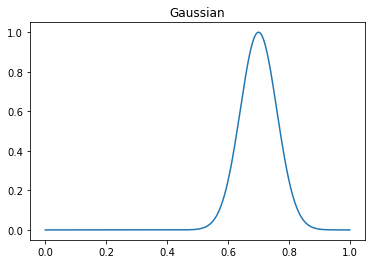

In [3]:
# Define Gaussian function:
def gauss(x, amplitude, mean, std):
    """Define a gaussian function"""
    return amplitude * np.exp(-((x-mean)/std)**2 / 2) 

# Choose parameters for Gaussian, evaluate, and store in an array, f.
std = 6e-2                           
mean = 0.7
amplitude_gaussian = 1  
gaussian = gauss(xc, amplitude_gaussian, mean, std)

fig, ax = plt.subplots(1, 1)
ax.plot(xc, gaussian)
ax.set_title("Gaussian")

Text(0.5, 1.0, 'Model, $m(x)$')

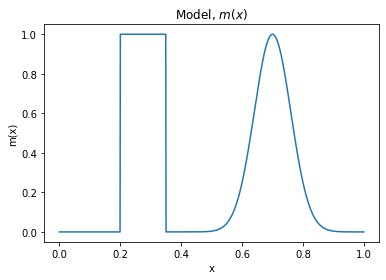

In [4]:
# Define a boxcar function:
x_boxcar = np.r_[0.2, 0.35]
amplitude_boxcar = 1
boxcar = np.zeros(n_cells)  # initialize an array of all zeros
boxcar_inds = (xc >= x_boxcar.min()) & (xc <= x_boxcar.max())  # find the indices of the boxcar
boxcar[boxcar_inds] = amplitude_boxcar 

# construct the model
mtrue = gaussian + boxcar
   
# Plot   
fig, ax = plt.subplots(1, 1)
ax.plot(xc, mtrue)
ax.set_xlabel('x')
ax.set_ylabel('m(x)')
ax.set_title('Model, $m(x)$')

Again, we define out kernel functions and averaging and volume matrices as before:

Text(0.5, 1.0, 'Kernel functions, $g(x)$')

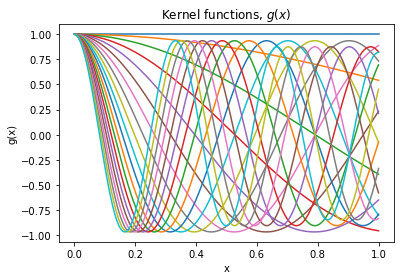

In [5]:
# Make the set of kernel functions

def kernel_functions(x, j, p, q): 
    return np.exp(-p*j*x) * np.cos(2*np.pi*q*j*x) 

p = 0.01  # Set values for p, q
q = 0.15
n_data = 20  # specify number of output data

j_min = 0
j_max = n_data
j_values = np.linspace(j_min, j_max, n_data)

Gn = np.zeros((n_nodes, n_data))

for i, j in enumerate(j_values):
    Gn[:, i] = kernel_functions(xn, j, p, q)
    
# Plot  
fig, ax = plt.subplots(1, 1)
ax.plot(xn, Gn)
ax.set_xlabel('x')
ax.set_ylabel('g(x)')
ax.set_title('Kernel functions, $g(x)$')

In [6]:
# Make Averaging Matrix
Av = np.zeros((n_cells, n_nodes)) # Create a matrix of zeros of the correct dimensions 

# and fill in with elements usin the loop below (note the 1/2 is included in here). 
for i in range(n_cells):
    Av[i, i] = 0.5  
    Av[i, i+1] = 0.5   

print(Av.shape)

(1000, 1001)


In [7]:
# make the Volume, "delta x" array
delta_x = np.diff(xn)  # set x-spacings
V = np.diag(delta_x)  # create diagonal matrix     

print(V.shape)

(1000, 1000)


Last, we produce our data:

In [8]:
G = Gn.T @ Av.T @ V

In [9]:
d = G @ mtrue

Text(0.5, 1.0, 'Synthetic Data $d$')

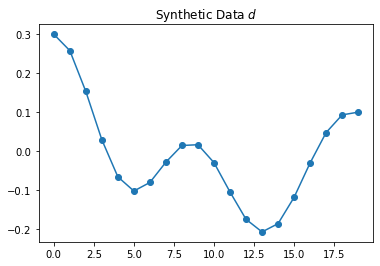

In [10]:
# Plot
fig, ax = plt.subplots(1, 1)
ax.plot(d, '-o')
ax.set_title('Synthetic Data $d$')

## Introducing noise to the data

This is where we stood at the end of the last module. Next, to simulate taking data in the field, we are going to add a noise to the data before we perform our inversion. We will do this by defining a lambda function that assigns a floor value and percent scaling factor. Also, we will assume that the noise is Gaussian. We then add the noise to the original data to make a simulated vector of observed data. The superposition of our noise and original data is plotted below.

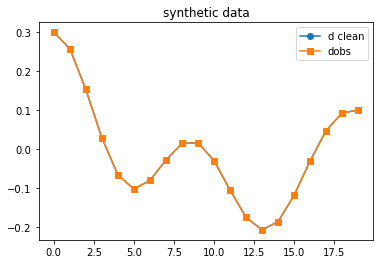

In [11]:
# Add noise to our synthetic data

add_noise = False  # set to true if you want to add noise to the data

if add_noise is True:
    relative_noise = 0.04
    noise_floor = 1e-2
    noise = (
        relative_noise * np.random.randn(n_data) * np.abs(d) +  # percent of data
        noise_floor * np.random.randn(n_data)
    )
    dobs = d + noise
else: 
    dobs = d

fig, ax = plt.subplots(1, 1)
ax.plot(d, '-o', label="d clean")
ax.plot(dobs, '-s', label="dobs")
ax.set_title("synthetic data")
ax.legend()

# Setting up the inverse problem

Now we will assemble the pieces for constructing an objective function to be minimized in the inversion. 

Throughout we use L2 norms, so the first thing we will do is define a simple function for computing a weighted L2 norm. 

In [12]:
def weighted_l2_norm(W, v):
    """
    A function that returns a weighted L2 norm. The parameter W is a weighting matrix 
    and v is a vector. 
    """
    Wv = W @ v
    return Wv.T @ Wv

## Calculating $\phi_d$

We are now in a position to build up the data misfit term, $\phi_d$. We will need a function to compute the 2-norm, so constructing a function to do this is useful. Next we will make the matrix $W_d$, which is a diagonal matrix that contains the inverses of the uncertainty in our data. Again, we will define a floor and percent error for each datum. Last, we calculate $\phi_d$ using our 2-norm function that we created. It is insightful to see what values have been assigned to our floor and misfit, so they are printed below.

Text(0.5, 1.0, 'Wd')

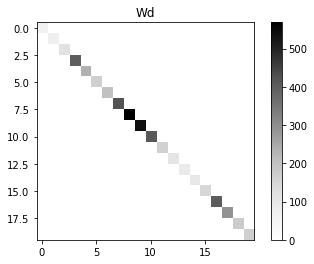

In [13]:
# Calculate the data misfit, phi_d

noise_floor = 1e-3
relative_error = 0.05
standard_deviation = noise_floor + relative_error * np.abs(dobs)

# construct Wd
Wd = np.diag(1/standard_deviation)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(Wd, "Greys")
plt.colorbar(img, ax=ax)
ax.set_title("Wd")

## Calculating $\phi_m$

As discussed above, we are going to first need to make our $W_m$ matrix, which is a partitioned matrix from two other matrices, $W_s$ and $W_x$, each scaled by a separate parameter $\alpha_s$ and $\alpha_x$. We are going to discuss the manner in which $\alpha_s$ and $\alpha_x$ are selected in more detail during the next module. But for the moment, we will set them as they are defined below. Once this matrix is built up, calculating $\phi_m$ is a simple matter, given that we have made a function to compute the 2-norm already. For the sake of illustration, I compute and print $\phi_m$ from the residual of our reference model $m_{ref}$ and our true model $m$. However, of interest to us will be the residual of the model that we recover $m_{rec}$ and our reference model.

In [14]:
# Start with Ws 
sqrt_vol = np.sqrt(delta_x)   # in 1D - the "Volume" = length of each cell (delta_x)
Ws = np.diag(sqrt_vol)

# and now Wx
Dx = np.zeros((n_cells-1, n_cells))  # differencing matrix

for i, dx in enumerate(delta_x[:-1]):
    Dx[i, i] = -1/dx
    Dx[i, i+1] = 1/dx

Wx = Dx @ np.diag(sqrt_vol)

print(Ws.shape, Wx.shape)

(1000, 1000) (999, 1000)


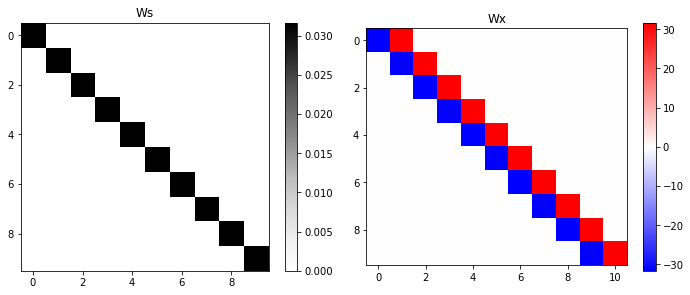

In [15]:
# plot both
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_up_to = 10 # plot 10 entries

# plot Ws
img = ax[0].imshow(Ws[:plot_up_to, :plot_up_to], "Greys")
plt.colorbar(img, ax=ax[0])
ax[0].set_title("Ws")

# plot Wx
img = ax[1].imshow(Wx[:plot_up_to, :plot_up_to+1], "bwr")
plt.colorbar(img, ax=ax[1])
ax[1].set_title("Wx")

plt.tight_layout()

### Stack Ws, Wx to make a single regularization matrix Wm

In [16]:
alpha_s = 1e-6
alpha_x = 1

Wm = np.vstack([
    np.sqrt(alpha_s)*Ws, 
    np.sqrt(alpha_x)*Wx
])

print(Wm.shape)

(1999, 1000)


## Inverting for our recovered model

At last we can invert to find our recovered model and see how it compares with the true model. First we will assign a value for $\beta$. As with the $\alpha$ parameters from before, we will assign  a value, but the choice of beta will be a topic that we explore more fully in the next module. Once our $\beta$ value is assigned, we will define yet another lambda function to obtain the recovered model, plot it against our true model, and then output our results for $\phi_d$ and $\phi_m$. 

In [17]:
beta = 1e-1  # Set beta value
mref = 0.5 * np.ones(n_cells)  # choose a reference model

WdG = Wd @ G
mrec = (
    np.linalg.inv(WdG.T @ WdG + beta * Wm.T @ Wm) @ 
    (WdG.T @ Wd @ dobs + beta * Wm.T @ Wm @ mref)
)

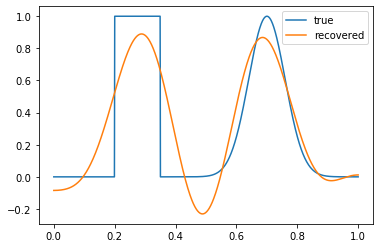

In [18]:
fig, ax = plt.subplots(1, 1)

ax.plot(xc, mtrue, label="true")
ax.plot(xc, mrec, label="recovered")
ax.legend()

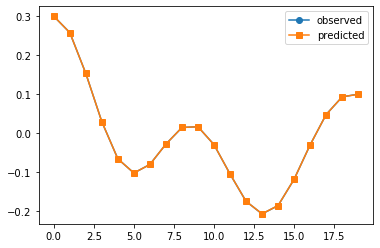

In [19]:
dpred = G @ mrec

fig, ax = plt.subplots(1, 1)
ax.plot(dobs, '-o', label="observed")
ax.plot(dpred, '-s', label="predicted")
ax.legend()

This concludes the current module. For the next module, we will examine the constraints on our choice for $\alpha_s$ and $\alpha_x$, and then introduce the Tikhonov curve and a method for choosing $\beta$.